<a href="https://colab.research.google.com/github/divyall/Data-Cleaning-and-Preprocessing-task1L1/blob/main/Task2_L2_Time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from google.colab import files


In [10]:
print("Please upload your CSV file...")
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

print("File loaded successfully!")
print("Shape:", df.shape)
print(df.head())

Please upload your CSV file...


Saving 4) house Prediction Data Set.csv to 4) house Prediction Data Set (2).csv
File loaded successfully!
Shape: (505, 1)
  0.00632  18.00   2.310  0  0.5380  6.5750  65.20  4.0900   1  296.0  15.30 396.90   4.98  24.00
0   0.02731   0.00   7.070  0  0.4690  6.4210  78...                                             
1   0.02729   0.00   7.070  0  0.4690  7.1850  61...                                             
2   0.03237   0.00   2.180  0  0.4580  6.9980  45...                                             
3   0.06905   0.00   2.180  0  0.4580  7.1470  54...                                             
4   0.02985   0.00   2.180  0  0.4580  6.4300  58...                                             


In [11]:
# Detect date column
date_col = None
for c in df.columns:
    parsed = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
    if parsed.notna().sum() / len(parsed) > 0.75:
        date_col = c
        break

if date_col:
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce", infer_datetime_format=True)
    df = df.set_index(date_col).sort_index()
    print("Using date column:", date_col)
else:
    df.index = pd.RangeIndex(len(df))
    print("No date-like column found; using row index.")


No date-like column found; using row index.


/tmp/ipython-input-702726293.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-702726293.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)


In [17]:
# Pick numeric column
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if not num_cols:
    raise ValueError("/content/4) house Prediction Data Set (3).csv.")

chosen = num_cols[0]  # pick first numeric column by default
print("Numeric columns:", num_cols)
print("Chosen column:", chosen)

series = df[chosen].astype(float).copy()
series = series.interpolate().fillna(method="ffill").fillna(method="bfill")


Numeric columns: ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13']
Chosen column: c0


/tmp/ipython-input-1321964435.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series.interpolate().fillna(method="ffill").fillna(method="bfill")


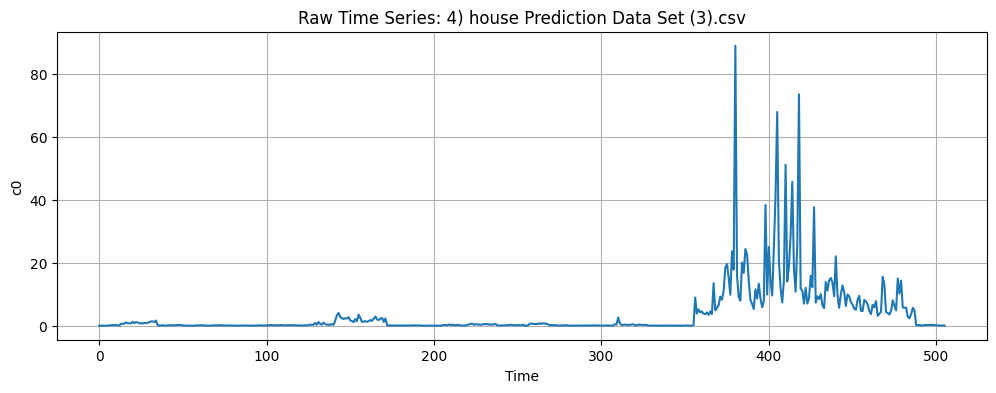

In [20]:
# plot raw series
plt.figure(figsize=(12,4))
plt.plot(series.index, series.values)
# Corrected f-string to handle parentheses in the filename
plt.title(f"Raw Time Series: {file_name}")
plt.xlabel("Time")
plt.ylabel(chosen)
plt.grid(True)
plt.show()

In [21]:
# Estimate seasonal period
if isinstance(series.index, pd.DatetimeIndex):
    span_days = (series.index.max() - series.index.min()).days
    period = 7 if span_days < 2*365 else 365
else:
    period = 12 if len(series) >= 24 else max(2, len(series)//2)
print("Estimated period:", period)


Estimated period: 12


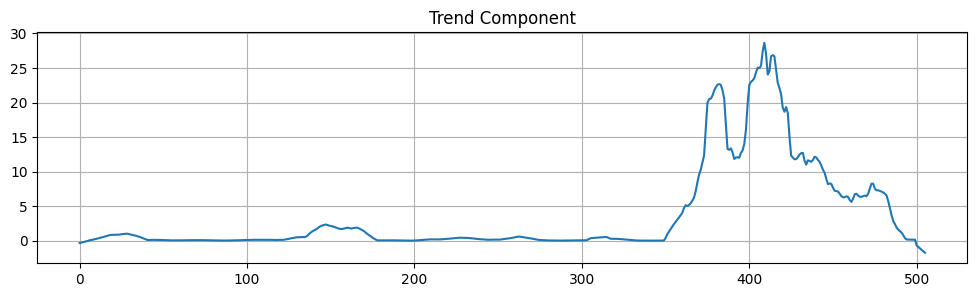

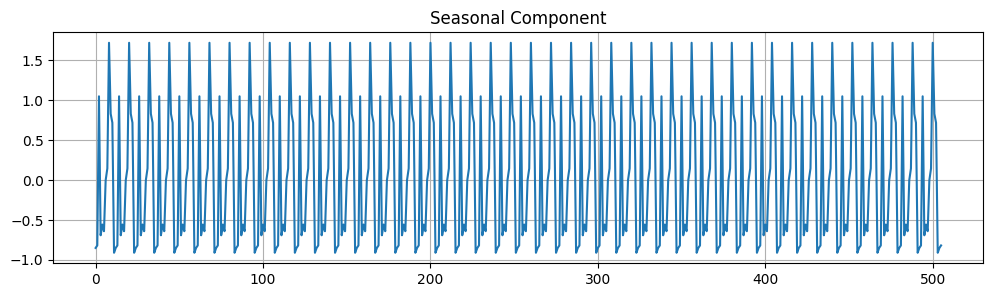

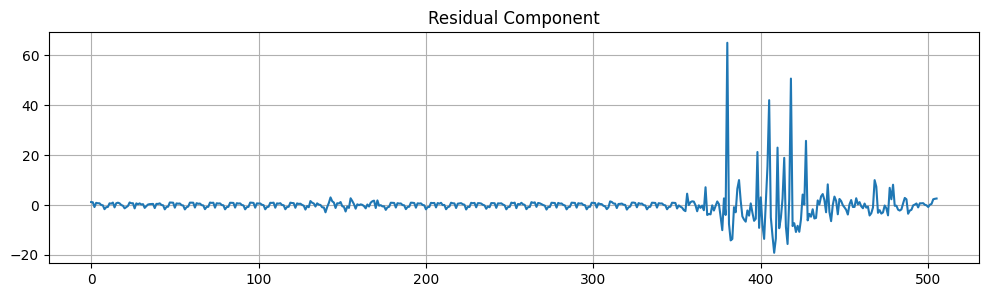

In [22]:
# Decompose
try:
    decomp = seasonal_decompose(series, model="additive", period=period, extrapolate_trend="freq")
    # Trend
    plt.figure(figsize=(12,3)); plt.plot(decomp.trend); plt.title("Trend Component"); plt.grid(True); plt.show()
    # Seasonality
    plt.figure(figsize=(12,3)); plt.plot(decomp.seasonal); plt.title("Seasonal Component"); plt.grid(True); plt.show()
    # Residuals
    plt.figure(figsize=(12,3)); plt.plot(decomp.resid); plt.title("Residual Component"); plt.grid(True); plt.show()
except Exception as e:
    print("Decomposition failed:", e)


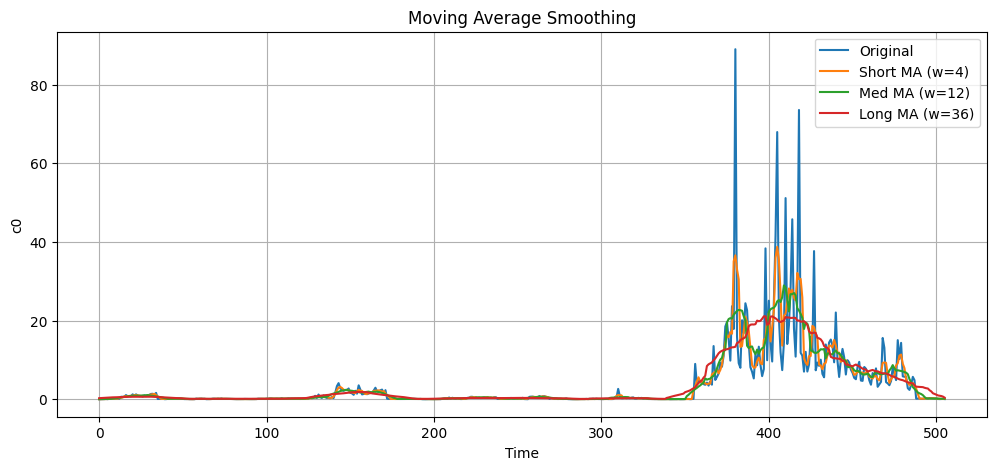

MA windows used -> Short: 4 Medium: 12 Long: 36


In [23]:
# Moving Average smoothing
short_w = max(3, int(round(period/3)))
med_w   = max(3, int(round(period)))
long_w  = max(3, int(round(period*3)))

short_ma = series.rolling(window=short_w, center=True, min_periods=1).mean()
med_ma   = series.rolling(window=med_w, center=True, min_periods=1).mean()
long_ma  = series.rolling(window=long_w, center=True, min_periods=1).mean()

plt.figure(figsize=(12,5))
plt.plot(series.index, series.values, label="Original")
plt.plot(short_ma.index, short_ma.values, label=f"Short MA (w={short_w})")
plt.plot(med_ma.index, med_ma.values, label=f"Med MA (w={med_w})")
plt.plot(long_ma.index, long_ma.values, label=f"Long MA (w={long_w})")
plt.title("Moving Average Smoothing")
plt.xlabel("Time")
plt.ylabel(chosen)
plt.legend()
plt.grid(True)
plt.show()

print("MA windows used -> Short:", short_w, "Medium:", med_w, "Long:", long_w)

In [24]:
if 'decomp' in locals():
    print("\nTrend Summary:", decomp.trend.dropna().describe())
    print("\nSeasonal Summary:", decomp.seasonal.dropna().describe())
    print("\nResidual Summary:", decomp.resid.dropna().describe())


Trend Summary: count    506.000000
mean       3.595309
std        6.506195
min       -1.721479
25%        0.103572
50%        0.380663
75%        3.620491
max       28.650170
Name: trend, dtype: float64

Seasonal Summary: count    506.000000
mean      -0.003298
std        0.852938
min       -0.910619
25%       -0.818561
50%       -0.556494
75%        0.719154
max        1.721366
Name: seasonal, dtype: float64

Residual Summary: count    506.000000
mean       0.021512
std        5.448015
min      -19.169741
25%       -0.970149
50%        0.008294
75%        0.755567
max       65.037477
Name: resid, dtype: float64
